In [16]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2

from tensorflow import keras
import json

In [2]:
def humansize(nbytes):
    '''From https://stackoverflow.com/questions/14996453/python-libraries-to-calculate-human-readable-filesize-from-bytes'''
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

In [7]:
# read in all image file names
image_path = "data/validation"
# image_path = os.path.abspath(image_path)
fns = os.listdir(image_path)
fns.sort()
fns = [
    os.path.join(image_path, fn)
    for fn in fns
]

In [8]:
print(fns[0])
x_val = np.zeros((len(fns), 224, 224, 3), dtype=np.float32)
print(humansize(x_val.nbytes))

data/validation/ILSVRC2012_val_00000001.JPEG
28.04 GB


## image preprocessing
(1) resize while keeping aspect ratio

(2) crop to 224x224

(3) conver from BGR to RGB

In [10]:
%%time

for i in range(len(fns)):
    if i %2000 == 0:
        print("%d/%d" % (i, len(fns)))
    
    # Load (as BGR)
    img = cv2.imread(fns[i])
    
    # Resize
    height, width, _ = img.shape
    new_height = height * 256 // min(img.shape[:2])
    new_width = width * 256 // min(img.shape[:2])
    #img.resize((new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Crop
    height, width, _ = img.shape
    startx = width//2 - (224//2)
    starty = height//2 - (224//2)
    img = img[starty:starty+224,startx:startx+224]
    assert img.shape[0] == 224 and img.shape[1] == 224, (img.shape, height, width)
    
    # Save (as RGB)
    x_val[i,:,:,:] = img[:,:,::-1]

0/50000
2000/50000
4000/50000
6000/50000
8000/50000
10000/50000
12000/50000
14000/50000
16000/50000
18000/50000
20000/50000
22000/50000
24000/50000
26000/50000
28000/50000
30000/50000
32000/50000
34000/50000
36000/50000
38000/50000
40000/50000
42000/50000
44000/50000
46000/50000
48000/50000
CPU times: user 15min 28s, sys: 4min 22s, total: 19min 50s
Wall time: 5min 4s


In [39]:
%%time

np.save("data/x_val.npy", x_val)

CPU times: user 11.3 ms, sys: 27.5 s, total: 27.6 s
Wall time: 27.6 s


## image label 

In [17]:
def load_class_index_data():
    ''' modified from keras
    '''
    CLASS_INDEX_PATH = ('https://s3.amazonaws.com/deep-learning-models/'
                    'image-models/imagenet_class_index.json')
    
    fpath = keras.utils.get_file(
            'imagenet_class_index.json',
            CLASS_INDEX_PATH,
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
            
    return CLASS_INDEX


def load_validation_file_label(path='data/val.txt'):
   
    file_to_label_map = {}
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            file_to_label_map[parts[0]] = parts[1]

    return file_to_label_map

In [24]:
label_to_name = load_class_index_data()
print(label_to_name['0'])
file_to_label = load_validation_file_label('data/val.txt')

['n01440764', 'tench']


In [29]:
y_val = []
for i in range(len(fns)):
    if i %5000 == 0:
        print("%d/%d" % (i, len(fns)))
    
    file_name = fns[i].split(os.sep)[-1]
    label = file_to_label[file_name]
    y_val.append(label)
    
np.save("data/y_val.npy", y_val)   


0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000
['65', '970', '230', '809', '516', '57', '334', '415', '674', '332']
65 ['n01751748', 'sea_snake']


In [30]:
# test
print(y_val[0:10])

for i in range(10):
    print(y_val[i], label_to_name[y_val[i]])

['65', '970', '230', '809', '516', '57', '334', '415', '674', '332']
65 ['n01751748', 'sea_snake']
970 ['n09193705', 'alp']
230 ['n02105855', 'Shetland_sheepdog']
809 ['n04263257', 'soup_bowl']
516 ['n03125729', 'cradle']
57 ['n01735189', 'garter_snake']
334 ['n02346627', 'porcupine']
415 ['n02776631', 'bakery']
674 ['n03794056', 'mousetrap']
332 ['n02328150', 'Angora']


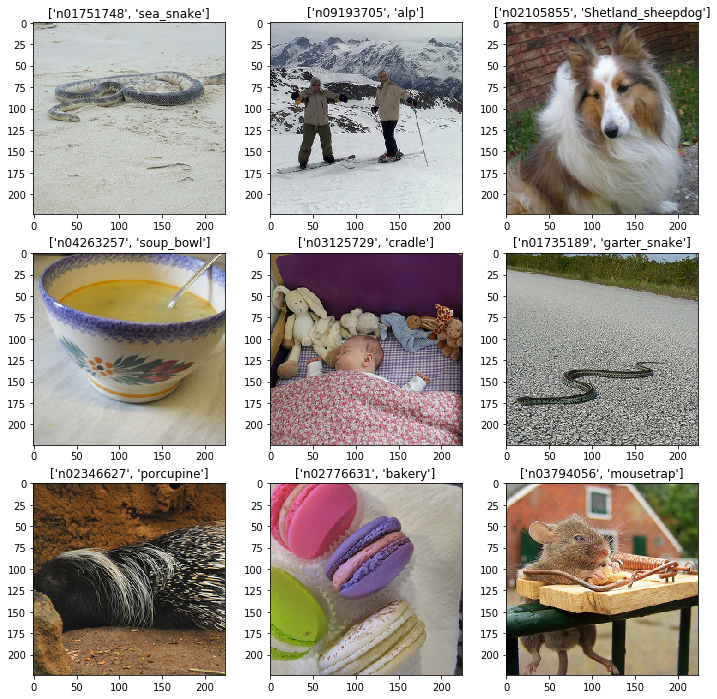

In [40]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_val[i] / 255.0)
    plt.title(label_to_name[y_val[i]])
    #plt.show()